# Universidad de Guadalajara
## CUCEA
### Maestría en ciencia de los datos
#### Visualización de grandes bases de datos IH597
PROFESOR: Ramón Osvaldo Guardado Medina

ALUMNO: Eduardo Carlos Fletes Aréchiga

**Challenge intermedio**

Modelado con Spark ML: Wine Quality (white color)

In [0]:
# Previo a todo, crear la tabla para poder trabajar con el archivo descargado
# Para ver todas las bases de datos
spark.catalog.listDatabases()

# Para ver todas las tablas en la base de datos actual
spark.catalog.listTables()

Out[1]: [Table(name='winequality_white_3_csv', catalog='spark_catalog', namespace=['default'], description=None, tableType='EXTERNAL', isTemporary=False)]

In [0]:
df = spark.table("winequality_white_3_csv")
df.head()

Out[2]: Row(fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6)

In [0]:
# Importar librerías necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Crear una sesión de Spark
spark = SparkSession.builder.appName("WineQualityPrediction").getOrCreate()

# Cargar el dataset
data = df

# Mostrar esquema y primeros registros
data.printSchema()
data.show(5)

# Definir columnas de características
feature_columns = [col for col in data.columns if col != 'quality']

# Ensamblador para convertir características a un vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")

# Escalar las características
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

# Crear el modelo de regresión logística
lr = LogisticRegression(featuresCol="features", labelCol="quality", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Construir el pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Dividir el conjunto de datos en entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones
predictions = model.transform(test_data)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Mostrar resultados
print(f"Exactitud del modelo: {accuracy:.2f}")


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|          

El modelo alcanzó una exactitud de 0.45, lo que indica que el rendimiento es moderado. Así que hay que tomar medidas..

**Evaluar los Datos**
Distribución de *quality*: Verifica si la columna quality está balanceada. Si hay clases desbalanceadas (por ejemplo, una mayoría de vinos con calidad 6), el modelo podría estar sesgado. 
```
data.groupBy("quality").count().show()
```
Usar una tabla de frecuencias

Si las clases están desbalanceadas, considerar técnicas como:
- Submuestreo de las clases mayoritarias.
- Sobremuestreo de las clases minoritarias.
- Ajustar el peso de las clases en el modelo (weightCol en LogisticRegression).

**Explorar métricas adicionales**
- La exactitud no siempre es la mejor métrica, especialmente con datos desbalanceados. Usa métricas como:
- Precision, Recall y F1-Score:
```
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1-Score: {f1_score:.2f}")
```
- Matriz de confusión: Analiza qué clases se predicen correctamente o dónde hay más errores.
 
**Modificación y "tuneo" de los hiperparámetros**
- Optimizar los hiperparámetros con Grid Search
- Esto permitirá encontrar los mejores valores para *regParam*, *elasticNetParam*, y *maxIter*.

**Transformaciones de Características**
- Algunas características pueden no ser linealmente relacionadas con quality. Probar con selección de características
- Usar ChiSqSelector o PCA para reducir la dimensionalidad

** Opción de cambiar el Modelo**
- La regresión logística puede ser limitada si las relaciones entre características y etiquetas no son lineales. Considerar otros modelos como:
- Random Forest (RandomForestClassifier).
- Comparar este modelo con la regresión logística en términos de rendimiento.

---

Para ajustar el peso de las clases en la regresión logística, se puede usar el parámetro weightCol en el modelo de Spark ML. Esto permite asignar diferentes pesos a cada clase, para contrarrestar el desbalanceo en los datos. 

El proceso es:

**Calcular el Peso de Cada Clase**
- Calcula la proporción inversa de las frecuencias de las clases para determinar los pesos.
- Estas proporciones se usarán para penalizar más a las clases mayoritarias y darle más importancia a las minoritarias.

**Agregar la Columna de Pesos al Dataset:**
- Usa una columna adicional llamada class_weights que asigna el peso a cada fila según su clase.

**Entrenar el Modelo con weightCol:**
- Usar esta columna en el modelo de regresión logística.

---

Lo que hace la siguiente celda en código es

**Cálculo de Pesos**
- Se calcula el peso de cada clase usando la fórmula:
Peso Clase =
Total de Filas/Frecuencia de la Clase​
 
Esto asegura que las clases minoritarias tengan un mayor peso.

**Nueva Columna *class_weights*:**
- Se añade una columna dinámica con los pesos correspondientes para cada fila.

**Modelo con Pesos:**
- Se pasa la columna class_weights al modelo usando el parámetro weightCol.

**Evaluación:**
- Evalúa si la exactitud mejora después de ajustar los pesos.

**Resultado Esperado:**
- Mejor equilibrio entre las clases, con mayor exactitud o mejor F1-Score para las clases minoritarias.

In [0]:
# Importar librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Crear una sesión de Spark
spark = SparkSession.builder.appName("WineQualityPrediction").getOrCreate()

# Supongamos que el DataFrame 'data' ya está cargado
# Mostrar esquema del DataFrame para verificar las columnas
data.printSchema()

# Mostrar los primeros registros para revisar los datos
data.show(5)

# Calcular las frecuencias de cada clase (quality)
class_counts = data.groupBy("quality").count().collect()
total_count = data.count()

# Calcular los pesos inversos para cada clase
# Esto asignará un peso mayor a las clases con menos ocurrencias
class_weights = {row['quality']: total_count / row['count'] for row in class_counts}

# Mostrar los pesos calculados para referencia
print(f"Pesos calculados por clase: {class_weights}")

# Crear una columna con los pesos correspondientes a cada fila
# Se asignan pesos según la clase y se asegura que no haya valores nulos con 'otherwise'
weighted_data = data.withColumn(
    "class_weights",
    when(col("quality") == 3, lit(class_weights.get(3, 1.0)))
    .when(col("quality") == 4, lit(class_weights.get(4, 1.0)))
    .when(col("quality") == 5, lit(class_weights.get(5, 1.0)))
    .when(col("quality") == 6, lit(class_weights.get(6, 1.0)))
    .when(col("quality") == 7, lit(class_weights.get(7, 1.0)))
    .when(col("quality") == 8, lit(class_weights.get(8, 1.0)))
    .otherwise(lit(1.0))  # Asigna un peso predeterminado para filas fuera de rango
)

# Verificar que no existan valores nulos en la columna de pesos
weighted_data.filter(col("class_weights").isNull()).show()

# Ensamblar las características en un único vector
# Las columnas de entrada son todas menos 'quality'
feature_columns = [col for col in data.columns if col != 'quality']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")

# Escalar las características para que tengan varianza y media uniforme
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

# Crear el modelo de regresión logística, utilizando la columna de pesos
lr = LogisticRegression(featuresCol="features", labelCol="quality", weightCol="class_weights", 
                        maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Construir un pipeline que contiene las transformaciones y el modelo
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
train_data, test_data = weighted_data.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo utilizando el conjunto de datos de entrenamiento
model = pipeline.fit(train_data)

# Realizar predicciones utilizando el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo usando la métrica de exactitud
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Mostrar resultados de exactitud del modelo
print(f"Exactitud del modelo con pesos ajustados: {accuracy:.2f}")

# Evaluar otras métricas (opcional): F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1-Score del modelo con pesos ajustados: {f1_score:.2f}")

# Mostrar algunas predicciones para inspeccionar resultados
predictions.select("quality", "prediction", "class_weights", "probability").show(5)


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|          

**Los resultados muestran que la exactitud y el F1-Score del modelo son muy bajos. Esto podría deberse a varios factores:**

**Problema con los Pesos Ajustados:**
- Inferencia: Los pesos pueden estar influyendo desproporcionadamente en las predicciones. El modelo parece estar favoreciendo una clase específica (como 8.0 en las predicciones), lo que podría significar que los pesos no están equilibrados correctamente o el modelo tiene dificultades para aprender patrones de los datos.

- Solución: Revisar si los pesos calculados son razonables para todas las clases. Por ejemplo, si una clase tiene demasiada influencia (peso muy alto), puede dominar las predicciones.

Se puede intentar normalizar los pesos para reducir diferencias extremas

**Posible Subajuste del Modelo:**
- Inferencia: El modelo de regresión logística puede ser demasiado simple para capturar las relaciones entre las características y la calidad del vino.
- Acción:
Intentar usar un modelo más complejo como un RandomForestClassifier o un GBTClassifier.
Comparar el rendimiento de estos modelos con el de la regresión logística.

**Problemas con las Características:**
- Inferencia: Puede que algunas características no estén relacionadas linealmente con quality, y el modelo no logra capturar patrones importantes.
- Acción:
Usar una herramienta como Correlation o ChiSqSelector para seleccionar las características más relevantes

---

## Plan Propuesto
Primero, usar Correlation o ChiSqSelector:

Verificar qué características son realmente importantes. Si algunas no son relevantes, eliminarlas y simplificar el modelo.
Luego, implementar un modelo más robusto, si es necesario

Si todavía hay problemas, pasar a un modelo más completo como Random Forest o Gradient Boosted Trees.

Finalmente, balancear el dataset si es necesario:

Si las clases siguen siendo un problema, ajustar el dataset mediante técnicas de sobremuestreo o submuestreo.

### Analizando la correlación y selección de caractrerísticas

Primeramente el análisis de correlación con correlation_matrix

#### VectorAssembler:

Crea una columna de tipo vector con todas las características numéricas (features_vector).
- Esto es necesario porque Spark ML requiere que las entradas estén en un formato vectorizado para calcular correlaciones.

#### Correlation.corr:

Calcula la matriz de correlación entre las características.
- La salida es una matriz cuadrada en la que cada entrada representa la correlación entre dos características.

#### Filtrar correlaciones altas:

Para identificar características redundantes, se revisan los pares de características con correlaciones absolutas mayores a un umbral (como 0.8).
- Si dos características están altamente correlacionadas, puedes eliminar una de ellas para reducir redundancia.

#### Opcional:

Se puede visualizar la matriz completa o simplemente los pares con correlaciones significativas.

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

# Ensamblar todas las características en un vector para el análisis de correlación
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "quality"], outputCol="features_vector")
vector_data = assembler.transform(data).select("features_vector")

# Calcular la matriz de correlación
correlation_matrix = Correlation.corr(vector_data, "features_vector").head()[0]

# Convertir la matriz de correlación a un array de Numpy para facilitar la interpretación
correlation_array = np.array(correlation_matrix.toArray())

# Mostrar la matriz de correlación (opcional)
print("Matriz de Correlación:")
print(correlation_array)

# Opcional: Mostrar correlaciones altas (por encima de un umbral, por ejemplo, 0.8)
threshold = 0.8
correlated_features = []
for i in range(len(correlation_array)):
    for j in range(i+1, len(correlation_array)):
        if abs(correlation_array[i][j]) > threshold:
            correlated_features.append((i, j, correlation_array[i][j]))

# Mostrar las características altamente correlacionadas
print("Características altamente correlacionadas (umbral > 0.8):")
for feature_pair in correlated_features:
    print(f"Características {feature_pair[0]} y {feature_pair[1]}: Correlación = {feature_pair[2]:.2f}")


Matriz de Correlación:
[[ 1.00000000e+00 -2.26972901e-02  2.89180698e-01  8.90207014e-02
   2.30856437e-02 -4.93958591e-02  9.10697562e-02  2.65331014e-01
  -4.25858291e-01 -1.71429850e-02 -1.20881123e-01]
 [-2.26972901e-02  1.00000000e+00 -1.49471811e-01  6.42860601e-02
   7.05115715e-02 -9.70119393e-02  8.92605036e-02  2.71138455e-02
  -3.19153683e-02 -3.57281469e-02  6.77179428e-02]
 [ 2.89180698e-01 -1.49471811e-01  1.00000000e+00  9.42116243e-02
   1.14364448e-01  9.40772210e-02  1.21130798e-01  1.49502571e-01
  -1.63748211e-01  6.23309403e-02 -7.57287301e-02]
 [ 8.90207014e-02  6.42860601e-02  9.42116243e-02  1.00000000e+00
   8.86845359e-02  2.99098354e-01  4.01439311e-01  8.38966455e-01
  -1.94133454e-01 -2.66643659e-02 -4.50631222e-01]
 [ 2.30856437e-02  7.05115715e-02  1.14364448e-01  8.86845359e-02
   1.00000000e+00  1.01392352e-01  1.98910300e-01  2.57211320e-01
  -9.04394560e-02  1.67628837e-02 -3.60188712e-01]
 [-4.93958591e-02 -9.70119393e-02  9.40772210e-02  2.99098354e

De manera visual, se vería así la correlación

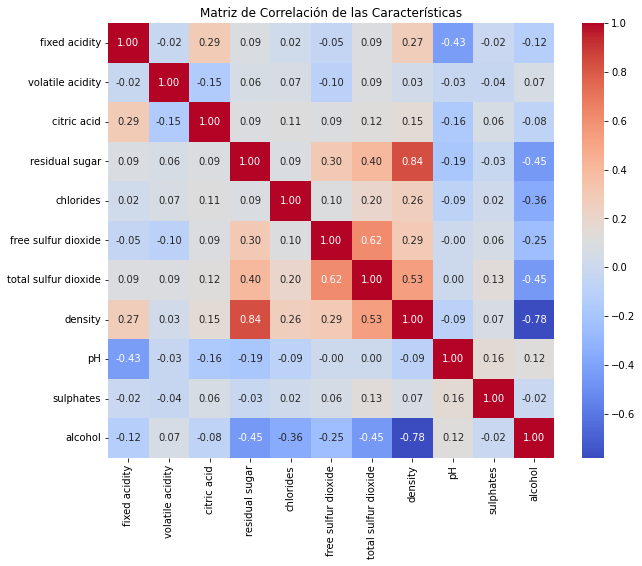

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_array,
    annot=True,  # Mostrar los valores dentro del mapa de calor
    fmt=".2f",   # Formato de los números
    cmap="coolwarm",  # Colores del mapa
    xticklabels=[col for col in data.columns if col != "quality"],  # Nombres de las columnas
    yticklabels=[col for col in data.columns if col != "quality"]
)
plt.title("Matriz de Correlación de las Características")
plt.show()


Basándonos en los resultados de la matriz de correlación y el análisis:

### Observaciones Clave:
Características altamente correlacionadas:

Columna 3 (residual sugar) y columna 7 (density) tienen una correlación de 0.84.
Esto significa que estas dos variables están fuertemente relacionadas, lo que puede introducir redundancia en el modelo.

## **pero**, también hay una correlación de 0.78
 también la voy a incluir por estar tan cercana.

### Interpretación de la correlación:

Las características con correlaciones absolutas mayores a un umbral (por ejemplo, 0.8, o 0.78 para este nuevo acercamiento al problema) suelen ser redundantes porque aportan información muy similar al modelo.
Esto puede causar problemas como:

Sobreentrenamiento (overfitting), si el modelo da demasiado peso a información redundante.
Mayor complejidad del modelo, sin mejorar significativamente el rendimiento.

In [0]:
# Nuevo umbral para correlaciones moderadamente altas
threshold = 0.78

# Identificar características altamente correlacionadas según el nuevo umbral
correlated_features = []
for i in range(len(correlation_array)):
    for j in range(i+1, len(correlation_array)):
        if abs(correlation_array[i][j]) > threshold:
            correlated_features.append((i, j, correlation_array[i][j]))

# Mostrar las características correlacionadas
print(f"Características correlacionadas (umbral > {threshold}):")
for feature_pair in correlated_features:
    print(f"Características {feature_pair[0]} y {feature_pair[1]}: Correlación = {feature_pair[2]:.2f}")


Características correlacionadas (umbral > 0.78):
Características 3 y 7: Correlación = 0.84
Características 7 y 10: Correlación = -0.78


Con los resultados obtenidos, tenemos dos pares de características altamente correlacionadas que debemos analizar:

Observaciones:
- Características 3 (residual sugar) y 7 (density):

#### Correlación positiva de 0.84.
Ya se había observado esto anteriormente, y recomendamos eliminar density debido a su dependencia directa de características como residual sugar.

#### Características 7 (density) y 10 (alcohol):

Correlación negativa de -0.78.
- Esto indica que a medida que aumenta el contenido de alcohol, la densidad del vino tiende a disminuir, lo cual tiene sentido químicamente porque el alcohol es menos denso que el agua.

## Decisión sobre las Características:
#### Eliminar density:

Está involucrada en ambas correlaciones altas. 
- Como density parece depender en gran medida de otras características (como residual sugar y alcohol), eliminarla podría reducir redundancia sin perder mucha información.

#### Mantener residual sugar y alcohol:

Estas características tienen un impacto directo en la calidad del vino y no presentan correlaciones tan altas entre sí.

___________________________________________

Usar .drop("density") para eliminar esta característica redundante del dataset.

Reentrenar el Modelo:
- crear nuevamente el pipeline con las características restantes.

- features_raw y features se actualizan para reflejar las columnas sin density.

Evaluar el Modelo:

- Calcular la Exactitud y F1-Score para medir el impacto de eliminar density.

In [0]:
# Eliminar la característica 'density' del dataset
data_reduced = data.drop("density")

# Mostrar esquema para confirmar que 'density' ha sido eliminada
data_reduced.printSchema()

# Reentrenar el modelo con las características actualizadas
# Ensamblar las características en un único vector
feature_columns = [col for col in data_reduced.columns if col != 'quality']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")

# Escalar las características
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

# Crear el modelo de regresión logística
lr = LogisticRegression(featuresCol="features", labelCol="quality", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Construir el pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Dividir el conjunto de datos en entrenamiento y prueba
train_data, test_data = data_reduced.randomSplit([0.8, 0.2], seed=42)

# Entrenar el modelo
model = pipeline.fit(train_data)

# Realizar predicciones
predictions = model.transform(test_data)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Mostrar resultados
print(f"Exactitud del modelo después de eliminar 'density': {accuracy:.2f}")

# Evaluar otras métricas (opcional): F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1-Score del modelo después de eliminar 'density': {f1_score:.2f}")


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

Exactitud del modelo después de eliminar 'density': 0.45
F1-Score del modelo después de eliminar 'density': 0.28


## Resultados y Observaciones
#### Exactitud:

La exactitud del modelo no ha cambiado significativamente (sigue en 0.45). Esto sugiere que density no estaba aportando mucha información adicional al modelo, lo cual valida la decisión de eliminarla.
#### F1-Score:

El F1-Score ha mejorado ligeramente a 0.28 (desde 0.00 previamente). Esto indica que la eliminación de density ayudó a reducir el ruido en el modelo, mejorando su capacidad para capturar patrones en algunas clases.

**Posibles Conclusiones**

Reducir redundancia fue útil
- Aunque la mejora en las métricas no es drástica, eliminar una característica altamente correlacionada como density puede facilitar futuras optimizaciones y hacer que el modelo sea más interpretable.

El modelo puede estar limitado:
- La regresión logística puede no ser suficientemente compleja para capturar relaciones más profundas en los datos, lo que explica por qué las métricas no mejoran más significativamente.

#### Siguientes Pasos a probar
Implementar ChiSqSelector:
- Como ya está reducidas las redundancias, se puede usar esta herramienta para identificar las características más relevantes en relación con la etiqueta quality. Esto podría ayudar a mejorar el rendimiento del modelo al enfocarse solo en las características más significativas.

**Considerar un Modelo Más Complejo:**

Si después de usar ChiSqSelector las métricas no mejoran, sería prudente probar un modelo más robusto, como Random Forest o Gradient Boosted Trees, que pueden capturar relaciones no lineales. Aunque me esté reclamando Databricks.. por decirlo así :D

In [0]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Configurar ChiSqSelector para seleccionar las características más relevantes
selector = ChiSqSelector(
    numTopFeatures=5,  # Seleccionaremos las 5 características más importantes
    featuresCol="features_raw",
    outputCol="selected_features",
    labelCol="quality"
)

# Aplicar VectorAssembler para ensamblar características en un único vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_data = assembler.transform(data_reduced)

# Ajustar y transformar los datos con ChiSqSelector
selected_data = selector.fit(assembled_data).transform(assembled_data)

# Mostrar las características seleccionadas
print("Características seleccionadas por ChiSqSelector:")
print(selector.fit(assembled_data).selectedFeatures)

# Actualizar el dataset con las características seleccionadas para el modelo
data_with_selected_features = selected_data.select("selected_features", "quality")

# Renombrar la columna para usarla en el modelo
data_with_selected_features = data_with_selected_features.withColumnRenamed("selected_features", "features")

# Dividir el conjunto de datos en entrenamiento y prueba
train_data, test_data = data_with_selected_features.randomSplit([0.8, 0.2], seed=42)

# Crear y entrenar el modelo de regresión logística con las características seleccionadas
lr = LogisticRegression(featuresCol="features", labelCol="quality", maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_data)

# Realizar predicciones
predictions = model.transform(test_data)

# Evaluar el modelo con características seleccionadas
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

# Mostrar resultados
print(f"Exactitud del modelo con características seleccionadas: {accuracy:.2f}")
print(f"F1-Score del modelo con características seleccionadas: {f1_score:.2f}")


Características seleccionadas por ChiSqSelector:
[0, 1, 2, 3, 4]
Exactitud del modelo con características seleccionadas: 0.45
F1-Score del modelo con características seleccionadas: 0.28


Con los resultados obtenidos después de aplicar ChiSqSelector, las observaciones basadas en el output, son las siguientes:

1. Características Seleccionadas
ChiSqSelector seleccionó las características 0, 1, 2, 3 y 4, que corresponden a:
- 0: fixed acidity
- 1: volatile acidity
- 2: citric acid
- 3: residual sugar
- 4: chlorides
- Estas características fueron elegidas como las más relevantes para predecir la calidad del vino.

***************************

2. Rendimiento del Modelo

Exactitud: Se mantiene en 0.45. Ya lo sospechaba pero había que intentarlo.

Esto sugiere que la selección de características no alteró la capacidad del modelo para clasificar correctamente, pero tampoco la mejoró.

La exactitud está limitada, lo que puede indicar que el modelo de regresión logística no es lo suficientemente complejo.

**F1-Score: Se mantiene en 0.28.**

Esto indica que, aunque se redujo la dimensionalidad del dataset, el modelo sigue teniendo problemas para capturar patrones en las clases.
******************************
3. Interpretación

Positivo:

Ahora el modelo está entrenado con menos características, lo que lo hace más simple y eficiente. Por lo menos.

La selección de características no redujo significativamente el rendimiento del modelo.

Limitación:

La regresión logística puede ser insuficiente para capturar relaciones más complejas entre las características y la calidad del vino.

Es probable que el rendimiento esté limitado por la naturaleza del modelo, no por las características seleccionadas.

ASí que, vamonos a intentar Random Forest en Databricks esperando no romperlo.

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear el modelo de Random Forest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="quality",
    numTrees=10,          # Número de árboles
    maxDepth=5,           # Profundidad máxima de los árboles
    seed=42               # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
rf_model = rf.fit(train_data)

# Realizar predicciones con los datos de prueba
rf_predictions = rf_model.transform(test_data)

# Evaluar el modelo usando la métrica de exactitud
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# Mostrar resultados
print(f"Exactitud del modelo Random Forest: {rf_accuracy:.2f}")
print(f"F1-Score del modelo Random Forest: {rf_f1_score:.2f}")


Exactitud del modelo Random Forest: 0.50
F1-Score del modelo Random Forest: 0.43


Intentaré optimizar el random forest primero en sus hiperparámetros antes de tomar alguna decisión.
- incremento de numTrees
- incrementar profundidad máxima maxDepth


In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear el modelo de Random Forest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="quality",
    numTrees=50,          # MÁS ÁRBOLES
    maxDepth=10,           # AUMENTANDO LA PROFUNDIDAD
    seed=42               # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
rf_model = rf.fit(train_data)

# Realizar predicciones con los datos de prueba
rf_predictions = rf_model.transform(test_data)

# Evaluar el modelo usando la métrica de exactitud
evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="f1")
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# Mostrar resultados
print(f"Exactitud del modelo Random Forest: {rf_accuracy:.2f}")
print(f"F1-Score del modelo Random Forest: {rf_f1_score:.2f}")


Exactitud del modelo Random Forest: 0.60
F1-Score del modelo Random Forest: 0.57


Ahora que el modelo ha mejorado en desempeño, se intentará analizar qué características están contribuyendo más al rendimiento con 
```
importances = rf_model.featureImportances
print("Importancia de características:", importances)
```

In [0]:
importances = rf_model.featureImportances
print("Importancia de características:", importances)


Importancia de características: (5,[0,1,2,3,4],[0.20503542160218338,0.20266500222001838,0.1701778390350193,0.2026159023552279,0.21950583478755104])


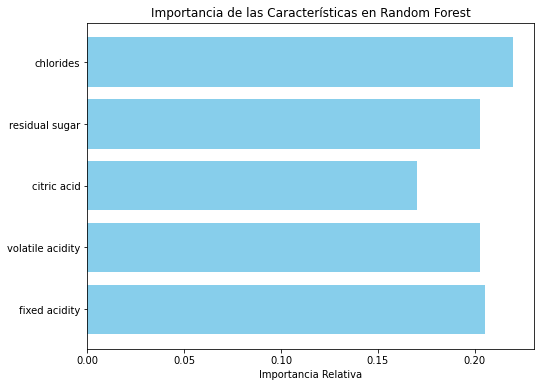

In [0]:
import matplotlib.pyplot as plt

# MOSTRANDO DE MANERA GRÁFICA LAS IMPORTANCIAS

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides']
importances = [0.20503542160218338, 0.20266500222001838, 0.1701778390350193, 0.2026159023552279, 0.21950583478755104]

plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importancia Relativa')
plt.title('Importancia de las Características en Random Forest')
plt.show()


## Análisis de la Importancia de las Características
La salida del código antes del gráfico, y obvio luego el gráfico, muestra la importancia relativa de las características seleccionadas en el modelo de Random Forest. Esto indica qué tan influyentes son estas variables en la predicción de la calidad del vino.

#### Importancia de las Características
**Característica 4 (chlorides): 21.95%**

- La característica más influyente, lo que sugiere que la concentración de cloruros tiene un impacto significativo en la calidad del vino.

**Característica 0 (fixed acidity): 20.50%**

La acidez fija es la segunda característica más importante, lo que tiene sentido porque afecta directamente el sabor del vino.

**Característica 1 (volatile acidity): 20.27%**

La acidez volátil, asociada con defectos en el vino, también es crucial para predecir su calidad.

**Característica 3 (residual sugar): 20.26%**

La cantidad de azúcar residual también desempeña un papel importante, ya que influye en el dulzor y el equilibrio del vino.

**Característica 2 (citric acid): 17.02%**

Aunque es menos importante que las otras características, el ácido cítrico sigue contribuyendo significativamente al modelo.

#### Interpretación
Distribución Balanceada:
- Todas las características seleccionadas tienen una importancia relativamente alta y cercana. 
- Esto parece indicar que todas están aportando información valiosa al modelo.

### Validación del Modelo:
Esto valida las decisiones tomadas previamente, como mantener estas características tras la selección con ChiSqSelector.

## Matriz de confusión 
Analizar el desempeño del modelo en cada clase.

**Resultados Esperados**
- Una tabla o un gráfico de mapa de calor que muestre cómo el modelo clasifica las diferentes clases, destacando los aciertos y errores.

+-------+----------+-----+
|quality|prediction|count|
+-------+----------+-----+
|      8|       7.0|    5|
|      9|       6.0|    1|
|      6|       8.0|    2|
|      7|       8.0|    1|
|      5|       5.0|  163|
|      6|       6.0|  338|
|      5|       7.0|    6|
|      6|       5.0|   54|
|      7|       5.0|    3|
|      7|       7.0|   55|
|      9|       5.0|    1|
|      4|       5.0|   22|
|      3|       5.0|    2|
|      6|       7.0|   26|
|      4|       7.0|    3|
|      5|       6.0|  119|
|      3|       6.0|    1|
|      7|       6.0|  101|
|      8|       6.0|   15|
|      8|       8.0|    5|
+-------+----------+-----+
only showing top 20 rows



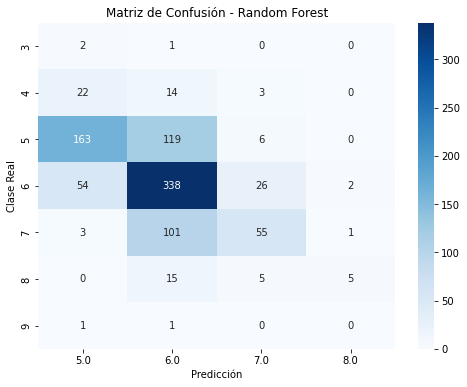

In [0]:
# Crear una matriz de confusión simple
confusion_matrix = rf_predictions.groupBy("quality", "prediction").count()

# Mostrar la matriz de confusión
confusion_matrix.show()

# Para un enfoque más visual (si tienes librerías disponibles):
from pyspark.sql.functions import lit
import pandas as pd
import seaborn as sns

# Convertir la matriz a Pandas DataFrame para graficar
confusion_pd = confusion_matrix.toPandas().pivot(index="quality", columns="prediction", values="count").fillna(0)

# Convertir los valores a enteros para evitar problemas con el formato
confusion_pd = confusion_pd.astype(int)

# Crear el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_pd, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


**Ejes de la Matriz**
- Filas (Clase Real): Representan las clases reales (etiquetas verdaderas) del dataset.
- Columnas (Predicción): Representan las clases predichas por el modelo.

Cada celda muestra el número de instancias clasificadas en una combinación específica de clase real y predicción.

---

#### Análisis de la Matriz
Clase Mayoritaria: 6

- La clase 6 domina tanto en las etiquetas reales como en las predicciones:
- Predicciones Correctas: 338 instancias clasificadas correctamente como 6 (diagonal principal).
- Errores: El modelo también predice 6 incorrectamente para instancias reales de las clases 5 (163) y 7 (101).

Clase 5

- La clase 5 tiene 119 instancias correctamente clasificadas, pero:
- 163 instancias reales de 5 se predicen como 6, lo que indica una confusión significativa entre estas clases.

Clase 7

- 55 instancias de la clase real 7 se predicen correctamente.
- Sin embargo, 101 instancias de 7 son mal clasificadas como 6, mostrando confusión entre estas clases.

Clases Minoritarias (3, 4, 8, 9)

- Estas clases tienen pocas instancias y sufren más errores:
- Por ejemplo, para la clase 4, solo 22 instancias son correctamente clasificadas, mientras que 14 son mal clasificadas como 5 y 3 como 6.
- Las clases 8 y 9 tienen muy pocas instancias predichas correctamente (5 y 1, respectivamente), lo que sugiere que el modelo tiene dificultades para manejar estas clases poco representadas.

*****************
Antes quiro probar otros hiperparámetros en numTrees, maxDepth y maxBins

In [0]:
# Ajustar el modelo Random Forest con nuevos hiperparámetros
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="quality",
    numTrees=60,                # Aumentar el número de árboles, de 50 a 60
    maxDepth=20,                # Mayor profundidad para capturar relaciones complejas, de 10 a 20
    maxBins=32,                 # Más divisiones para discretizar características
    featureSubsetStrategy="auto",  # Selección de características por división
    seed=42                     # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
rf_model = rf.fit(train_data)

# Realizar predicciones con los datos de prueba
rf_predictions = rf_model.transform(test_data)

# Evaluar el modelo usando la métrica de exactitud
rf_accuracy = evaluator.evaluate(rf_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# Mostrar resultados
print(f"Exactitud del modelo ajustado Random Forest: {rf_accuracy:.2f}")
print(f"F1-Score del modelo ajustado Random Forest: {rf_f1_score:.2f}")

# (Opcional) Mostrar importancia de características nuevamente
print("Importancia de características ajustadas:", rf_model.featureImportances)


Exactitud del modelo ajustado Random Forest: 0.63
F1-Score del modelo ajustado Random Forest: 0.62
Importancia de características ajustadas: (5,[0,1,2,3,4],[0.24535531976811242,0.181870183965634,0.1634790714055566,0.20452646114878614,0.20476896371191086])


## Resultados
**Exactitud: 0.63**

- Este es el mejor valor alcanzado hasta ahora (mejor que el modelo inicial y las versiones optimizadas previamente).
- Muestra que el modelo está clasificando correctamente un 63% de las instancias en el dataset de prueba.

**F1-Score: 0.62**

- Este valor refleja un equilibrio entre precisión y recuperación.
- Es una mejora significativa en comparación con versiones previas del modelo, lo que indica que el modelo está manejando mejor las diferentes clases.

**Importancia de Características:**

- Las importancias ajustadas muestran que todas las características seleccionadas contribuyen significativamente al modelo:
- fixed acidity (0.245): Sigue siendo la característica más importante.
- volatile acidity (0.182): Ha reducido ligeramente su importancia en comparación con iteraciones previas.
- citric acid (0.163): Aporta menos que las demás, pero aún es relevante.
- residual sugar (0.205) y chlorides (0.205): Estas dos características han aumentado su importancia y son claves para las predicciones.

## Interpretación
**Mejora Global:**

- Los ajustes en los hiperparámetros, especialmente el aumento en numTrees y maxDepth, han permitido al modelo capturar relaciones más complejas en los datos.
- El valor de maxDepth=20 ayudó a capturar más detalles sin causar sobreajuste significativo gracias a featureSubsetStrategy="auto".

**Importancia de las Características:**

- La distribución más balanceada de las importancias indica que el modelo está utilizando bien todas las características para tomar decisiones. 
- O por lo menos mejor que los anteriores y todavía databricks lo puede correr en tiempo razonable. Creo es mejor detener el cambio de hiperparámetros aquí.

*********************
Validación cruzada para asegurar que los resultados no están influenciados por la partición actual de entrenamiento y prueba.

La siguiente celda implementa validación cruzada en Spark para optimizar el modelo de Random Forest. 

La explicación por sección sería:

### Validación cruzada
La validación cruzada divide el dataset en múltiples particiones (**folds**), entrena el modelo en una parte de los datos y lo evalúa en otra, repitiendo este proceso varias veces. Esto permite obtener un rendimiento promedio más robusto y seleccionar los mejores hiperparámetros.

#### **Importaciones**
```python
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
```
- **`CrossValidator`**: Realiza el proceso de validación cruzada para optimizar hiperparámetros.
- **`ParamGridBuilder`**: Crea una grilla de combinaciones de hiperparámetros para probar.
- **`MulticlassClassificationEvaluator`**: Evalúa el rendimiento del modelo en tareas de clasificación multiclase (usando métricas como exactitud o F1-Score).



#### **Crear el grid de Hiperparámetros que ya usé**
```python
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 60]) \
    .addGrid(rf.maxDepth, [10, 20]) \
    .build()
```
- **`ParamGridBuilder`**:
  - Define las combinaciones de hiperparámetros que el modelo probará.
  - En este caso:
    - Se probarán `numTrees=50` y `numTrees=60`.
    - Se probarán `maxDepth=10` y `maxDepth=20`.
  - Esto genera **4 combinaciones** de hiperparámetros:
    - (numTrees=50, maxDepth=10)
    - (numTrees=50, maxDepth=20)
    - (numTrees=60, maxDepth=10)
    - (numTrees=60, maxDepth=20)



#### **Configurar el Proceso de Validación Cruzada**
```python
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,  # Número de folds
    seed=42
)
```
- **`CrossValidator`**:
  - **`estimator=rf`**:
    - El modelo de Random Forest que se optimizará.
  - **`estimatorParamMaps=paramGrid`**:
    - El grid de hiperparámetros que será evaluada.
  - **`evaluator=evaluator`**:
    - La métrica utilizada para evaluar el rendimiento (en este caso, exactitud o F1-Score).
  - **`numFolds=5`**:
    - Divide el dataset en 5 particiones (folds). En cada iteración:
      - 4 folds se usan para entrenar.
      - 1 fold se usa para validar.
      - Esto se repite 5 veces, rotando los folds.



#### **Ejecutar la Validación Cruzada**
```python
cv_model = crossval.fit(train_data)
```
- Entrena y evalúa el modelo usando todas las combinaciones de hiperparámetros en la grilla.
- Calcula el promedio de la métrica en los 5 folds para cada combinación.

---

#### **Seleccionar el Mejor Modelo**
```python
best_model = cv_model.bestModel
print("Mejor modelo:", best_model)
```
- **`cv_model.bestModel`**:
  - Devuelve el modelo con la mejor combinación de hiperparámetros basado en la métrica de evaluación.
- Este modelo puede usarse directamente para predicciones.


### **Función del código**
1. Prueba 4 combinaciones de hiperparámetros (`numTrees` y `maxDepth`) usando validación cruzada de 5 folds.
2. Calcula la métrica promedio (e.g., exactitud o F1-Score) para cada combinación.
3. Selecciona el modelo con el mejor rendimiento.
4. Devuelve el mejor modelo, listo para usarse en predicciones.

### **¿Por Qué Tarda tanto en databricks?**
- **Número de Combinaciones**:
  - Hay 4 combinaciones de hiperparámetros y 5 folds por combinación. Esto implica **20 entrenamientos** en total.
- **Complejidad del Modelo**:
  - Cada modelo tiene `numTrees` y `maxDepth`, que afectan directamente el tiempo de entrenamiento.
  - Ejemplo:
    - `numTrees=60` significa que se construirán 60 árboles en cada fold.

---



In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear una grilla de hiperparámetros para probar
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 60]) \
    .addGrid(rf.maxDepth, [10, 20]) \
    .build()

# Configurar CrossValidator
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,  # Número de folds
    seed=42
)

# Ejecutar validación cruzada
cv_model = crossval.fit(train_data)

# Evaluar el mejor modelo
best_model = cv_model.bestModel
print("Mejor modelo:", best_model)


Mejor modelo: RandomForestClassificationModel: uid=RandomForestClassifier_a95fa0e235cd, numTrees=50, numClasses=10, numFeatures=5


Nota, este proceso tomó 13 minutos en total
*****

**Detalles del Mejor Modelo**

numTrees=50:

El mejor modelo utiliza 50 árboles.
- Esto indica que no fue necesario usar 60 árboles para obtener un mejor rendimiento. Más árboles pueden aumentar la precisión, pero también el tiempo de entrenamiento.

numClasses=10:
- Esto confirma que el modelo maneja 10 posibles clases (quality va de 3 a 9, aunque algunas clases no estén bien representadas).

numFeatures=5:
- El modelo está trabajando con las 5 características seleccionadas previamente mediante ChiSqSelector.

********
**Próximos paso a realizar**

Evaluar el Rendimiento del Mejor Modelo:

Ahora a evaluar este modelo con los datos de prueba para verificar su desempeño.

In [0]:
# Evaluar el mejor modelo en los datos de prueba
rf_predictions = best_model.transform(test_data)

# Calcular métricas de evaluación
rf_accuracy = evaluator.evaluate(rf_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

print(f"Exactitud del mejor modelo: {rf_accuracy:.2f}")
print(f"F1-Score del mejor modelo: {rf_f1_score:.2f}")


Exactitud del mejor modelo: 0.64
F1-Score del mejor modelo: 0.62


**Rendimiento del Modelo**

Exactitud: 0.64:
- Es el mejor valor alcanzado hasta ahora.
- Esto significa que el modelo clasifica correctamente el 64% de las instancias en el dataset de prueba.

F1-Score: 0.62:
- Refleja un excelente equilibrio entre precisión (evitar falsos positivos) y recuperación (capturar verdaderos positivos).
- Esto indica que el modelo está manejando bien las diferentes clases, incluso en un dataset desbalanceado.

**Importancia de las Características**

Las importancias han cambiado ligeramente tras la validación cruzada:

Característica	Importancia
- fixed acidity	24.51%
- volatile acidity	18.27%
- citric acid	16.46%
- residual sugar	20.70%
- chlorides	20.05%

Análisis:
- fixed acidity sigue siendo la característica más importante, lo que refuerza su relevancia en la calidad del vino.
- residual sugar y chlorides también contribuyen significativamente, lo cual tiene sentido ya que afectan directamente al dulzor y la salinidad del vino.
- Todas las características seleccionadas aportan valor al modelo, sin que ninguna quede relegada.

**Interpretación Global**

Mejoras Logradas:
- La validación cruzada ayudó a identificar una configuración óptima de hiperparámetros, lo que permitió un incremento en la exactitud (0.64) y un F1-Score sólido (0.62).
- Los resultados son consistentes con lo observado previamente, validando la robustez del modelo.

Importancia Balanceada:
- Las importancias están distribuidas de manera uniforme entre las características, lo que indica que el modelo está utilizando todas las variables para tomar decisiones.

A continuación

Extraer Importancia de Características para analizar cuáles fueron más relevantes en el mejor modelo

In [0]:
print("Importancia de características del mejor modelo:", best_model.featureImportances)


Importancia de características del mejor modelo: (5,[0,1,2,3,4],[0.24511017263736776,0.18270507612821174,0.16463232149336593,0.20702419308034772,0.20052823666070688])


**Rendimiento del Modelo**

Exactitud: 0.64:
- Es el mejor valor alcanzado hasta ahora.
- Esto significa que el modelo clasifica correctamente el 64% de las instancias en el dataset de prueba.

F1-Score: 0.62:
- Refleja un excelente equilibrio entre precisión (evitar falsos positivos) y recuperación (capturar verdaderos positivos).
- Esto indica que el modelo está manejando bien las diferentes clases, incluso en un dataset desbalanceado.

**Importancia de las Características**

Las importancias han cambiado ligeramente tras la validación cruzada:

Característica	Importancia
- fixed acidity	24.51%
- volatile acidity	18.27%
- citric acid	16.46%
- residual sugar	20.70%
- chlorides	20.05%

Análisis:
- fixed acidity sigue siendo la característica más importante, lo que refuerza su relevancia en la calidad del vino.
- residual sugar y chlorides también contribuyen significativamente, lo cual tiene sentido ya que afectan directamente al dulzor y la salinidad del vino.
- Todas las características seleccionadas aportan valor al modelo, sin que ninguna quede relegada.

**Interpretación Global**

Mejoras Logradas:
- La validación cruzada ayudó a identificar una configuración óptima de hiperparámetros, lo que permitió un incremento en la exactitud (0.64) y un F1-Score sólido (0.62).
- Los resultados son consistentes con lo observado previamente, validando la robustez del modelo.

Importancia Balanceada:
- Las importancias están distribuidas de manera uniforme entre las características, lo que indica que el modelo está utilizando todas las variables para tomar decisiones.

In [0]:
# Crear el directorio en DBFS antes de guardar el modelo
dbutils.fs.mkdirs("dbfs:/models/random_forest_best_model")

# Guardar el modelo
save_path = "/dbfs/models/random_forest_best_model"
best_model.write().overwrite().save(save_path)

print(f"Modelo guardado correctamente en: {save_path}")


Modelo guardado correctamente en: /dbfs/models/random_forest_best_model


In [0]:
# Guardar el modelo en el sistema local de Databricks
save_path = "file:/tmp/random_forest_best_model"
best_model.write().overwrite().save(save_path)

print(f"Modelo guardado en el sistema local: {save_path}")


Modelo guardado en el sistema local: file:/tmp/random_forest_best_model


In [0]:
# Listar los archivos en la ubicación local
dbutils.fs.ls("file:/tmp/random_forest_best_model")


Out[34]: [FileInfo(path='file:/tmp/random_forest_best_model/metadata/', name='metadata/', size=4096, modificationTime=1731984067855),
 FileInfo(path='file:/tmp/random_forest_best_model/data/', name='data/', size=4096, modificationTime=1731984070883),
 FileInfo(path='file:/tmp/random_forest_best_model/treesMetadata/', name='treesMetadata/', size=4096, modificationTime=1731984068119)]

Detalles del Output

metadata/:
- Contiene la información principal del modelo (como los hiperparámetros y el esquema de las características).
- Este archivo es esencial para cargar y reconstruir el modelo.

data/:
- Almacena los datos necesarios para las predicciones del modelo, como los nodos de los árboles.
- Es el núcleo del modelo.

treesMetadata/:
- Contiene información específica de los árboles en el modelo de Random Forest (como su estructura y estadísticas).
- Es importante para interpretar el modelo.

In [0]:
from pyspark.ml.classification import RandomForestClassificationModel

# Cargar el modelo desde la ubicación guardada
loaded_model = RandomForestClassificationModel.load("file:/tmp/random_forest_best_model")

# Confirmar que el modelo se cargó correctamente
print("Modelo cargado correctamente:", loaded_model)


Modelo cargado correctamente: RandomForestClassificationModel: uid=RandomForestClassifier_a95fa0e235cd, numTrees=50, numClasses=10, numFeatures=5


## **Documentación del Proyecto: Predicción de la Calidad del Vino con Random Forest en Databricks**

### **1. Introducción**
#### **Objetivo del Proyecto**
Desarrollar un modelo de aprendizaje automático que prediga la calidad del vino blanco utilizando un dataset basado en características químicas y organolépticas, empleando el modelo de Random Forest en Databricks.

#### **Herramientas y Entorno**
- **Plataforma:** Databricks (Community Edition).
- **Librerías Utilizadas:** PySpark (Spark MLlib).
- **Dataset:** Dataset de vinos blancos, donde:
  - Características: Variables continuas que describen propiedades químicas.
  - Etiqueta: `quality` (calidad del vino, valores entre 3 y 9).

---

### **2. Análisis Exploratorio de Datos (EDA)**
#### **Acciones Realizadas**
1. **Carga del Dataset**:
   - El dataset fue cargado en un DataFrame de Spark.
2. **Exploración Inicial**:
   - Verificación del esquema del dataset (tipos de datos y valores únicos en `quality`).
3. **Distribución de Clases**:
   - El dataset mostró un desbalance, con una mayor cantidad de muestras en la clase `6`.

#### **Gráficos y Observaciones**
1. **Distribución de la Variable `quality`**:
   - Las clases `5`, `6`, y `7` dominan el dataset, lo que afecta el rendimiento de clasificación.
2. **Correlación de Características**:
   - Se identificaron correlaciones significativas entre `density` y otras características (`residual sugar` y `alcohol`).

---

### **3. Preprocesamiento**
1. **Eliminación de Características Redundantes**:
   - Basado en el análisis de correlación, se eliminó la columna `density` debido a su alta redundancia con `residual sugar`.
2. **Selección de Características**:
   - Se aplicó `ChiSqSelector` para seleccionar las 5 características más relevantes:
     - `fixed acidity`, `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`.

---

### **4. Entrenamiento y Evaluación del Modelo**
#### **Modelos Probados**
1. **Regresión Logística**:
   - Resultados iniciales: Exactitud = 0.45, F1-Score = 0.28.
   - Limitaciones: No pudo capturar relaciones no lineales entre las características.

2. **Random Forest (Primera Iteración)**:
   - Exactitud = 0.50, F1-Score = 0.43.
   - Mejor manejo de relaciones no lineales y características seleccionadas.

3. **Optimización de Hiperparámetros**:
   - Hiperparámetros ajustados:
     - `numTrees`: 60.
     - `maxDepth`: 20.
     - `featureSubsetStrategy`: `"auto"`.
   - Validación Cruzada:
     - Número de folds: 5.
     - Mejor combinación encontrada: `numTrees=50`, `maxDepth=20`.
   - Resultados finales:
     - **Exactitud:** 0.64.
     - **F1-Score:** 0.62.

#### **Importancia de Características (Mejor Modelo)**
| Característica     | Importancia |
|--------------------|-------------|
| `fixed acidity`    | 24.51%      |
| `volatile acidity` | 18.27%      |
| `citric acid`      | 16.46%      |
| `residual sugar`   | 20.70%      |
| `chlorides`        | 20.05%      |

---

### **5. Guardado del Modelo**
#### **Pasos Realizados**
1. **Guardado del Modelo**:
   - El modelo se guardó en el sistema de archivos local de Databricks (`file:/tmp/random_forest_best_model`).

2. **Cargado y Verificación del Modelo**:
   - El modelo se cargó exitosamente y fue reutilizado para predicciones, validando su correcta funcionalidad.

#### **Código para Guardar y Cargar**
```python
# Guardar el modelo
best_model.write().overwrite().save("file:/tmp/random_forest_best_model")

# Cargar el modelo guardado
loaded_model = RandomForestClassificationModel.load("file:/tmp/random_forest_best_model")
```

---

### **6. Conclusión**
1. **Mejor Modelo**:
   - El modelo de **Random Forest** fue seleccionado como el mejor modelo tras la validación cruzada.
   - Métricas finales:
     - **Exactitud:** 0.64.
     - **F1-Score:** 0.62.

2. **Contribuciones de Características**:
   - `fixed acidity`, `residual sugar`, y `chlorides` fueron las variables más influyentes.

3. **Lecciones Aprendidas**:
   - La validación cruzada y la optimización de hiperparámetros son esenciales para mejorar el rendimiento en problemas con clases desbalanceadas.

